In [1]:
suffix = '91-120'

infile = 'chap' + suffix + '.txt'
outfile = 'chap' + suffix + '.gexf'
figfile_centr = 'chap' + suffix + '_centr.png'
figfile_distr = 'chap' + suffix + '_distr.png'

In [2]:
infile = 'fulltext.txt'
outfile = 'fulltext.gexf'
figfile_centr = 'fulltext_centr.png'
figfile_distr = 'fulltext_distr.png'

# Import the files

In [3]:
import re

# Read the file containing the text

with open(infile, 'r') as file:
    data = file.read().replace('\n', ' ')

text = re.sub('[^A-Za-z0-9]+', ' ', data)

In [4]:
# Read the file containing the characters and put them in a list

chars = []

with open("characters.txt", 'r') as file:
    for line in file:
        name = line.strip().lower()
        chars.append(name)

# Create tokens and n-grams

In [5]:
import nltk
from nltk.stem.snowball import SnowballStemmer

stopWords = nltk.corpus.stopwords.words('english')

def wordTokens(text, stop_words):
    """
    Tokenization of a string in word tokens
    
    :param text: A string
    :param stop_words: A list of stop words to not be considered in the final tokens

    :return: A list of word tokens
    """
    wtokens = nltk.word_tokenize(text.lower())
    wtokens = [w for w in wtokens if w not in stop_words]

    return wtokens


In [6]:
# Create the n-grams

tokens = wordTokens(text, stopWords)
bigrm = nltk.bigrams(tokens)
bigrms = list(bigrm)
trigrm = nltk.trigrams(tokens)
trigrms = list(trigrm)

# Count interactions

In [7]:
import numpy as np

def char_tuple_f(chars_list):
    char_tuples_list = []
    for char in chars:
        tup = tuple(char.split(" "))
        char_tuples_list.append(tup)
    return char_tuples_list


def indices_dic(char_tuples, words, bigr, trigr):
    dic = {}
    for tup in char_tuples:
        char_name = " ".join(tup)
        n = len(tup)
        if n == 1:
            indices = [i for i, x in enumerate(words) if x == tup]
        elif n == 2:
            indices = [i for i, x in enumerate(bigr) if x == tup]
        elif n == 3:
            indices = [i for i, x in enumerate(trigr) if x == tup]
        dic[char_name] = np.array(indices)
    
    return dic

def links_dic_f(indices_dic, threshold):
    
    link_dic = {}
    for first_char, ind_arr1 in indices_dic.items():
        dic = {}
        for second_char, ind_arr2 in indices_dic.items():
            if first_char == second_char:
                continue

            matr = np.abs(ind_arr1[np.newaxis].T - ind_arr2) <= threshold
            s = np.sum(matr)
            if s > 3:
                dic[second_char] = s
        link_dic[first_char] = dic
    
    return link_dic


char_tuples = char_tuple_f(chars)
ind_dic = indices_dic(char_tuples, tokens, bigrms, trigrms)
grand_dic = links_dic_f(ind_dic, 15)

# Merge nicknames

In [8]:
def merge_nickname(dic, mainname, nickname):
    for key in dic[nickname]:
        if key in dic[mainname]:
            dic[mainname][key] += dic[nickname][key]
        elif key==mainname:
            continue
        else:
            dic[mainname][key] = dic[nickname][key]

    for key in dic:
        if key==mainname:
            dic[key].pop(nickname, None)
            continue

        if nickname in dic[key]:
            if mainname in dic[key]:
                dic[key][mainname] += dic[key][nickname]
            else:
                dic[key][mainname] = dic[key][nickname]

        dic[key].pop(nickname, None)

    dic.pop(nickname, None)
    
    return dic

def merge_all_nicknames(dic, nickname_list):
    for tup in nickname_list:
        (mainname, nickname) = tup
        dic = merge_nickname(dic, mainname, nickname)
    return dic


#nick_list = []
#grand_dic = merge_all_nicknames(grand_dic, nick_list)

# Remove characters with no interactions

In [9]:
def remove_zero_link_chars(grand_dic, chars_list):
    rem_set = set()
    for key in grand_dic:
        if grand_dic[key] == {}:
            rem_set.add(key)
    
    fin_list = [char for char in chars_list if char not in rem_set]
    return fin_list


new_chars = remove_zero_link_chars(grand_dic, chars)

# Create the nodes and edges of the graph

In [10]:
def edge_tuples_f(grand_dic):
    edges_tuples = []
    for key in grand_dic:
        for item, value in grand_dic[key].items():
            tup = (key.title(), item.title(), value/100)
            edges_tuples.append(tup)

    return edges_tuples


edges_tuples = edge_tuples_f(grand_dic)

In [11]:
def convert_to_capitals(char_list):
    conv_list = []
    for char in char_list:
        conv_list.append(char.title())
    
    return conv_list


node_chars = convert_to_capitals(new_chars)

# Create the graph

In [12]:
import networkx as nx

G = nx.Graph()
G.add_nodes_from(node_chars)
G.add_weighted_edges_from(edges_tuples)

# Detect communities

In [13]:
import community

partition = community.best_partition(G)
nx.set_node_attributes(G, partition, 'group')

# Export .gexf file

In [14]:
nx.write_gexf(G, outfile)

# Calculate centralities

In [15]:
import pandas as pd

def calc_centralities(graph):
    dgc = nx.degree_centrality(graph)
    dgc = pd.DataFrame.from_dict(dgc, orient='index', columns=["DGC"])
    btc = nx.betweenness_centrality(graph)
    btc = pd.DataFrame.from_dict(btc, orient='index', columns=["BTC"])
    evc = nx.eigenvector_centrality(graph, weight='weight')
    evc = pd.DataFrame.from_dict(evc, orient='index', columns=["EVC"])
    #pr = nx.pagerank(G)
    #pr = pd.DataFrame.from_dict(pr, orient='index', columns=["PR"])
    df = pd.concat([dgc, btc, evc], axis=1)
    return df

df = calc_centralities(G)

In [16]:
df["DGC_norm"] = df.DGC/df.DGC.max()
df["BTC_norm"] = df.BTC/df.BTC.max()
df["EVC_norm"] = df.EVC/df.EVC.max()
df["total"] =  0.3*df.DGC_norm + 0.3*df.BTC_norm + 0.4*df.EVC_norm
df.sort_values("total", ascending=False)

,DGC,BTC,EVC,DGC_norm,BTC_norm,EVC_norm,total
Cao Cao,0.782609,0.263024,0.483625,1.000000,1.000000,0.915554,0.966222
Liu Bei,0.623188,0.112483,0.528233,0.796296,0.427653,1.000000,0.767185
Zhuge Liang,0.550725,0.171935,0.313863,0.703704,0.653685,0.594175,0.644887
Guan Yu,0.434783,0.046480,0.317970,0.555556,0.176713,0.601951,0.460461
Sun Quan,0.376812,0.036351,0.176238,0.481481,0.138205,0.333638,0.319361
Lu Bu,0.333333,0.034134,0.192741,0.425926,0.129777,0.364880,0.312663
Zhang Fei,0.304348,0.011738,0.240102,0.388889,0.044626,0.454538,0.311870
Zhao Zilong,0.362319,0.035772,0.149678,0.462963,0.136003,0.283356,0.293032
Yuan Shao,0.333333,0.024906,0.165691,0.425926,0.094691,0.313670,0.281653
Zhou Yu,0.304348,0.018557,0.154413,0.388889,0.070552,0.292321,0.254760


# Create the centralities plot

In [17]:
import matplotlib.pyplot as plt

def plot_centrality(centr, df, title, n, col_list):
    
    ax = plt.subplot(1, 3, n)
    s = df.sort_values(centr, ascending=False)[:10]
    x = list(s[centr].index)[::-1]
    y = list(s[centr])[::-1]
    
    for i, v in enumerate(y):
        bars = plt.barh(x[i], v, color=col_list[n-1])
        #plt.text(v-0.217, i-0.09, str(x[i]), fontweight=400, size=20)
    
    plt.title(title, size=22)
    ax.get_xaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='y', length = 0, labelsize=14)


col_list = ["peachpuff", "plum", "orange"]
fig, ax = plt.subplots(1,3, figsize=(15, 10))
plot_centrality("DGC", df, 'Degree Centrality', 1, col_list)
plot_centrality("BTC", df, 'Betweeness Centrality', 2, col_list)
plot_centrality("EVC", df, 'Eigenvector Centrality', 3, col_list)
#lot_centrality("PR", df, 'PageRank Centrality', 4)
plt.savefig(figfile_centr, dpi=300)

# Create the interactions distribution plot

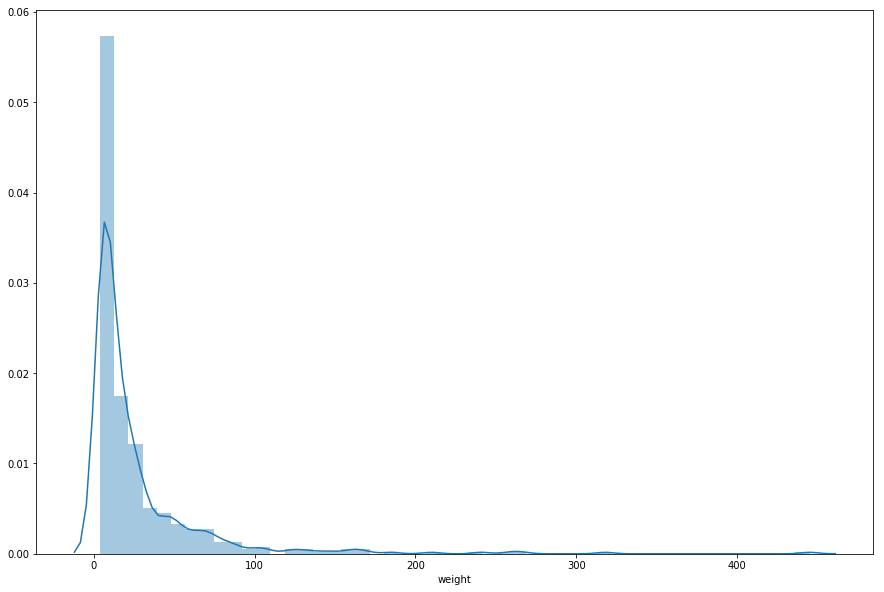

In [18]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15, 10))

edge_df = nx.to_pandas_edgelist(G)
s = edge_df["weight"]*100

ax = sns.distplot(s)
plt.savefig(figfile_distr, dpi=300)

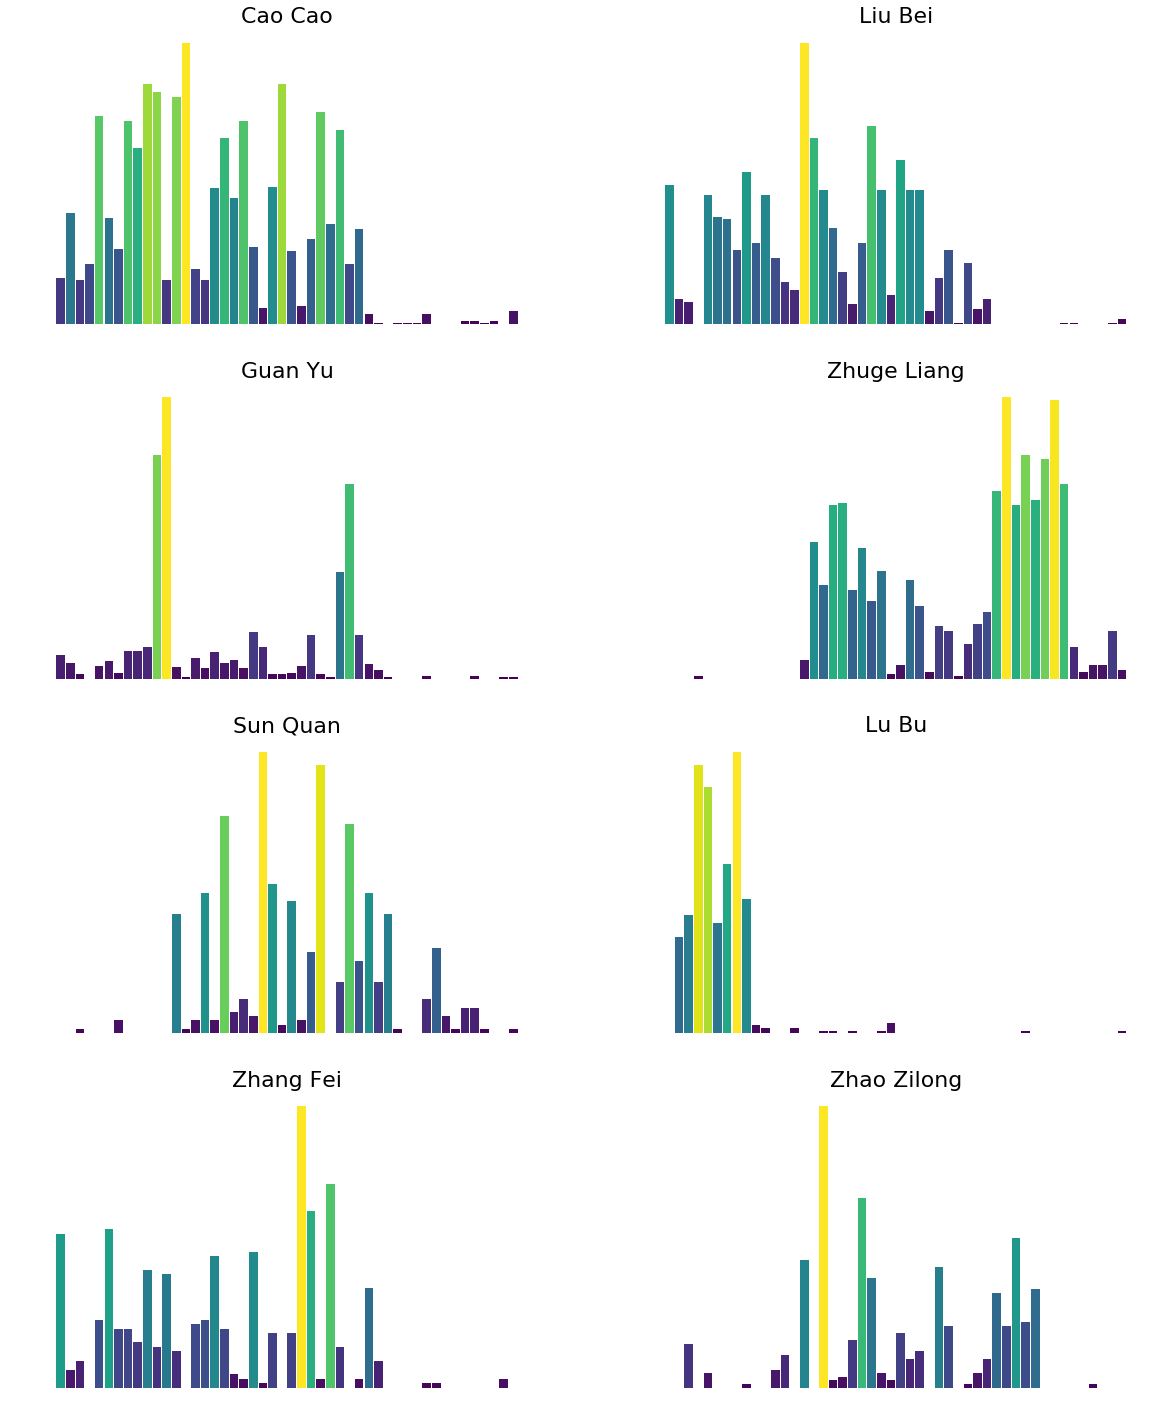

In [19]:
from matplotlib import cm

def get_x_y(sries, bins, lbl):
    c = pd.cut(sries, bins, labels=lbl)
    df = pd.concat([c, sries], axis=1)
    df.columns = ["bins", "s"]
    gb = df.groupby("bins").count()["s"]
    x = list(gb.index)
    x = np.array(x)/max(x)
    y = np.array(gb)
    return x, y



n = len(bigrms)
sel_char_list = ["cao cao", "liu bei", "guan yu", "zhuge liang",
                "sun quan", "lu bu", "zhang fei", "zhao zilong"]

bins = np.arange(0, n+6500, 6500)
lbl = np.arange(0, n, 6500)
fig, ax = plt.subplots(4, 2, figsize=(20, 25))

for i, char in enumerate(sel_char_list):
    
    ax = plt.subplot(4, 2, i+1)
    sries = pd.Series(ind_dic[char])
    plt.title(char.title(), size=22)
    x, y = get_x_y(sries, bins, lbl)
    colors = cm.viridis(np.array(y) / float(max(np.array(y))))
    ax.bar(x, y, width=0.019, color = colors)
    ax.axis('off')

plt.show()
#plt.savefig("time_plot.png", dpi=300)
